In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from copulas.multivariate import GaussianMultivariate

Step 1: Synthetic historical data generated

Quantiles for each feature:
Asset_A: 10% = -0.024095, 50% = 0.001565, 90% = 0.024056
Asset_B: 10% = -0.019011, 50% = 0.000640, 90% = 0.018577
Asset_C: 10% = -0.033650, 50% = 0.002625, 90% = 0.041429

Correlation Matrix:
[[ 1.          0.69862794 -0.25634305]
 [ 0.69862794  1.         -0.03292349]
 [-0.25634305 -0.03292349  1.        ]]

Step 2: Generating scenarios using copula method

Forecast quantiles (20% higher than historical):
Asset_A: 10% = -0.028914, 50% = 0.001878, 90% = 0.028867
Asset_B: 10% = -0.022813, 50% = 0.000768, 90% = 0.022292
Asset_C: 10% = -0.040380, 50% = 0.003150, 90% = 0.049715

Fitting copula model...


/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6338: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6338: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/scipy/stats/_continuous_

Generating 1000 scenarios...

Quantile comparison (forecast vs. generated):

Asset_A:
  10% quantile - Target: -0.028914, Generated: -0.026911
  50% quantile - Target: 0.001878, Generated: 0.001679
  90% quantile - Target: 0.028867, Generated: 0.030352

Asset_B:
  10% quantile - Target: -0.022813, Generated: -0.022447
  50% quantile - Target: 0.000768, Generated: 0.001986
  90% quantile - Target: 0.022292, Generated: 0.024416

Asset_C:
  10% quantile - Target: -0.040380, Generated: -0.038760
  50% quantile - Target: 0.003150, Generated: 0.004358
  90% quantile - Target: 0.049715, Generated: 0.051881

Correlation in generated scenarios:
          Asset_A   Asset_B   Asset_C
Asset_A  1.000000  0.738247 -0.254422
Asset_B  0.738247  1.000000 -0.038944
Asset_C -0.254422 -0.038944  1.000000


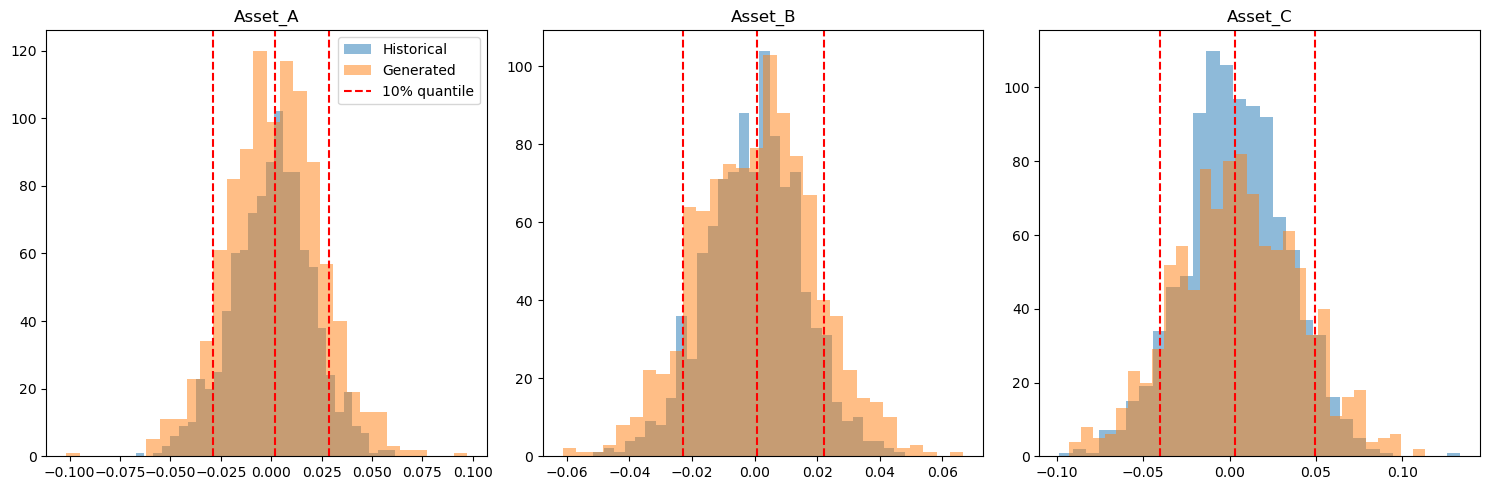

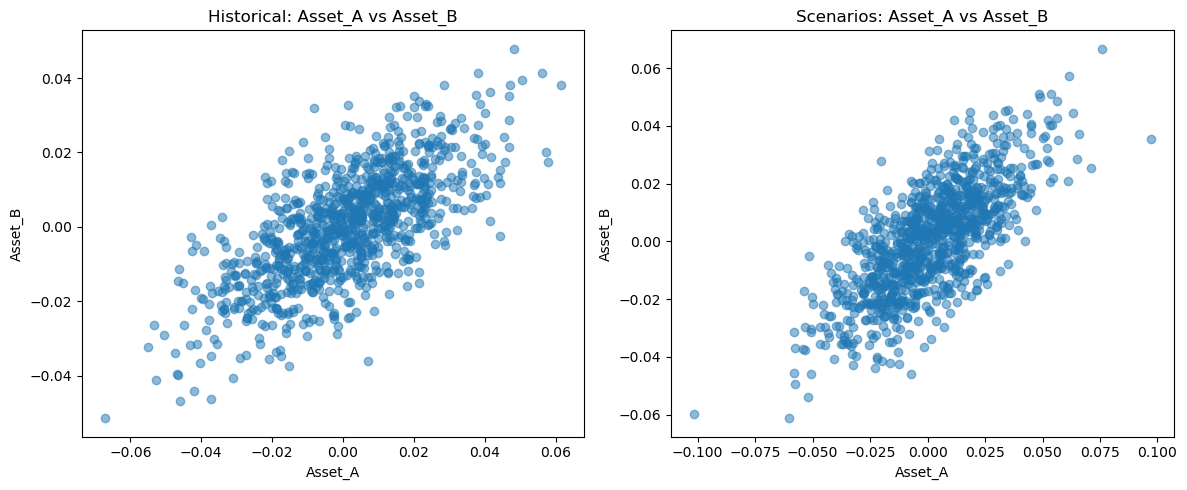

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from copulas.multivariate import GaussianMultivariate

################################################################################
# STEP 1: GENERATE SAMPLE DATA AND CALCULATE QUANTILES
################################################################################

# Create synthetic historical data for three features
np.random.seed(42)
n_samples = 1000

# Create correlation structure
correlation = np.array([
    [1.0, 0.7, -0.3],
    [0.7, 1.0, -0.1],
    [-0.3, -0.1, 1.0]
])

# Scale the correlation to create a covariance matrix with different variances
std_devs = np.array([0.02, 0.015, 0.03])  # Standard deviations for each feature
cov_matrix = np.outer(std_devs, std_devs) * correlation

# Generate synthetic return data with this correlation structure
feature_names = ['Asset_A', 'Asset_B', 'Asset_C']
means = np.array([0.001, 0.0005, 0.002])  # Mean returns
historical_data = np.random.multivariate_normal(mean=means, cov=cov_matrix, size=n_samples)

# Convert to DataFrame
returns = pd.DataFrame(historical_data, columns=feature_names)

# Calculate key quantiles (10%, 50%, 90%) for each feature
quantiles = {}
for feature in feature_names:
    quantiles[feature] = {
        0.1: np.percentile(returns[feature], 10),
        0.5: np.percentile(returns[feature], 50),
        0.9: np.percentile(returns[feature], 90)
    }

print("Step 1: Synthetic historical data generated")
print("\nQuantiles for each feature:")
for feature, q in quantiles.items():
    print(f"{feature}: 10% = {q[0.1]:.6f}, 50% = {q[0.5]:.6f}, 90% = {q[0.9]:.6f}")

print("\nCorrelation Matrix:")
print(returns.corr().values)

################################################################################
# STEP 2: SCENARIO GENERATION USING COPULA WITH QUANTILES
################################################################################

def fit_normal_to_quantiles(q_dict):
    """Fit a normal distribution to match the specified quantiles"""
    q_levels = list(q_dict.keys())
    q_values = list(q_dict.values())
    
    # For normal distribution, median = mean
    mean = q_values[1]  # 50% quantile
    
    # Calculate standard deviation from the difference between quantiles
    std = (q_values[2] - q_values[0]) / (stats.norm.ppf(q_levels[2]) - stats.norm.ppf(q_levels[0]))
    
    return {'loc': mean, 'scale': std}

print("\nStep 2: Generating scenarios using copula method")

# Fit marginal distributions for each feature based on quantiles
dist_params = {feature: fit_normal_to_quantiles(q) for feature, q in quantiles.items()}

# For scenario generation, let's modify the quantiles to represent a forecast
# This simulates a situation where your forecast quantiles are different from historical
forecast_quantiles = {}
for feature, q in quantiles.items():
    # Simulate a forecast with slightly higher returns
    forecast_quantiles[feature] = {
        k: v * 1.2 for k, v in q.items()  # 20% higher returns in our forecast
    }

print("\nForecast quantiles (20% higher than historical):")
for feature, q in forecast_quantiles.items():
    print(f"{feature}: 10% = {q[0.1]:.6f}, 50% = {q[0.5]:.6f}, 90% = {q[0.9]:.6f}")

# Fit distributions to the forecast quantiles
forecast_dist_params = {feature: fit_normal_to_quantiles(q) for feature, q in forecast_quantiles.items()}

# Generate synthetic training data that follows our forecast distributions and historical correlation
n_training_samples = 5000
np.random.seed(42)

# Get the historical correlation
historical_corr = returns.corr().values

# Generate correlated standard normal samples
Z = np.random.multivariate_normal(
    mean=np.zeros(len(feature_names)),
    cov=historical_corr,  # Use historical correlation
    size=n_training_samples
)

# Transform to match our forecast distributions
X = np.zeros_like(Z)
for i, feature in enumerate(feature_names):
    params = forecast_dist_params[feature]
    # Convert to uniform using standard normal CDF
    uniform = stats.norm.cdf(Z[:, i])
    # Convert to target distribution using inverse CDF
    X[:, i] = stats.norm.ppf(uniform, loc=params['loc'], scale=params['scale'])

# Convert to DataFrame for copula fitting
training_df = pd.DataFrame(X, columns=feature_names)

# Fit the Gaussian copula to the training data
print("\nFitting copula model...")
copula = GaussianMultivariate()
copula.fit(training_df)

# Generate scenarios using the fitted copula
n_scenarios = 1000
print(f"Generating {n_scenarios} scenarios...")
scenarios = pd.DataFrame(copula.sample(n_scenarios))
scenarios.columns = feature_names

# Validate results by checking if quantiles are preserved
print("\nQuantile comparison (forecast vs. generated):")
for feature, q_dict in forecast_quantiles.items():
    print(f"\n{feature}:")
    for q, target in q_dict.items():
        actual = np.percentile(scenarios[feature], q * 100)
        print(f"  {int(q*100)}% quantile - Target: {target:.6f}, Generated: {actual:.6f}")

print("\nCorrelation in generated scenarios:")
print(scenarios.corr())

# Plot distribution comparison
plt.figure(figsize=(15, 5))
for i, feature in enumerate(feature_names):
    plt.subplot(1, 3, i+1)
    
    # Plot original return distribution
    plt.hist(returns[feature], bins=30, alpha=0.5, label='Historical')
    
    # Plot generated scenario distribution
    plt.hist(scenarios[feature], bins=30, alpha=0.5, label='Generated')
    
    # Mark the forecast quantiles
    for q, val in forecast_quantiles[feature].items():
        plt.axvline(val, color='r', linestyle='--', 
                   label=f'{int(q*100)}% quantile' if q == 0.1 else None)
    
    plt.title(feature)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Plot scatter of scenarios to visualize correlation preservation
plt.figure(figsize=(12, 5))

# Original data scatter
plt.subplot(1, 2, 1)
plt.scatter(returns[feature_names[0]], returns[feature_names[1]], alpha=0.5)
plt.title(f'Historical: {feature_names[0]} vs {feature_names[1]}')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

# Generated scenarios scatter
plt.subplot(1, 2, 2)
plt.scatter(scenarios[feature_names[0]], scenarios[feature_names[1]], alpha=0.5)
plt.title(f'Scenarios: {feature_names[0]} vs {feature_names[1]}')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from copulas.multivariate import GaussianMultivariate

################################################################################
# STEP 1: DATA ACQUISITION AND QUANTILE CALCULATION
################################################################################

# Download historical stock data for three different assets
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

# Get historical data - FIX: Handle the data structure correctly
print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Extract adjusted close prices
# The structure of raw_data might vary based on the yfinance version
if isinstance(raw_data.columns, pd.MultiIndex):
    # If data has MultiIndex columns (ticker is part of the column index)
    data = raw_data['Adj Close']
else:
    # If the data structure is different, try to extract Adj Close for each ticker
    data = pd.DataFrame()
    for ticker in tickers:
        ticker_data = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = ticker_data['Adj Close']

# Calculate returns
returns = data.pct_change().dropna()

# The rest of the code remains the same...

[*********************100%***********************]  3 of 3 completed

KeyError: 'Adj Close'

In [7]:
raw_data.columns

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from copulas.multivariate import GaussianMultivariate

################################################################################
# STEP 1: DATA ACQUISITION AND QUANTILE CALCULATION
################################################################################

# Download historical stock data for three different assets
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

# Get historical data
print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Extract close prices - adjusted based on your MultiIndex structure
# Since 'Adj Close' is not in the columns, we'll use 'Close' instead
data = raw_data['Close']  # This selects the 'Close' price for all tickers

# Calculate returns
returns = data.pct_change().dropna()

# Calculate key quantiles (10%, 50%, 90%) for each asset
quantiles = {}
for ticker in tickers:
    quantiles[ticker] = {
        0.1: np.percentile(returns[ticker], 10),
        0.5: np.percentile(returns[ticker], 50),
        0.9: np.percentile(returns[ticker], 90)
    }

# Store correlation structure
correlation_matrix = returns.corr().values

print("Quantiles for each asset:")
for ticker, q in quantiles.items():
    print(f"{ticker}: 10% = {q[0.1]:.6f}, 50% = {q[0.5]:.6f}, 90% = {q[0.9]:.6f}")

print("\nCorrelation Matrix:")
print(correlation_matrix)

[*********************100%***********************]  3 of 3 completed

Quantiles for each asset:
AAPL: 10% = -0.022912, 50% = 0.000989, 90% = 0.023947
MSFT: 10% = -0.021891, 50% = 0.000978, 90% = 0.023125
GOOGL: 10% = -0.023868, 50% = 0.001056, 90% = 0.023858

Correlation Matrix:
[[1.         0.6913747  0.77700313]
 [0.6913747  1.         0.7726429 ]
 [0.77700313 0.7726429  1.        ]]


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)
data = raw_data['Close']  # Using Close prices
returns = data.pct_change().dropna()

# Define the quantiles we want to calculate
quantile_levels = [0.1, 0.5, 0.9]  # 10%, 50%, 90%

# Create empty DataFrame to hold the quantiles for each day (forward-looking)
# We'll use a 20-day rolling window
window_size = 20
quantile_df = pd.DataFrame(index=returns.index[window_size:])

# Calculate rolling quantiles for each asset and each quantile level
for ticker in tickers:
    for q in quantile_levels:
        col_name = f"{ticker}_{int(q*100)}%"
        rolling_quantile = returns[ticker].rolling(window=window_size).quantile(q)
        quantile_df[col_name] = rolling_quantile.iloc[window_size:]


[*********************100%***********************]  3 of 3 completed

In [13]:
quantile_df

,AAPL_10%,AAPL_50%,AAPL_90%,MSFT_10%,MSFT_50%,MSFT_90%,GOOGL_10%,GOOGL_50%,GOOGL_90%
Date,,,,,,,,,
2020-02-03,-0.015093,0.002915,0.021253,-0.010545,0.005876,0.020074,-0.012703,0.005146,0.020887
2020-02-04,-0.015093,0.002915,0.022057,-0.010545,0.006316,0.024762,-0.015636,0.003060,0.013824
2020-02-05,-0.015093,0.004193,0.022057,-0.010545,0.006316,0.024762,-0.015636,0.003060,0.013824
2020-02-06,-0.015093,0.004193,0.022057,-0.010545,0.006316,0.024762,-0.015636,0.003060,0.020290
2020-02-07,-0.015174,0.002915,0.022057,-0.010545,0.005876,0.024762,-0.015636,0.001986,0.020290
...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.009590,-0.000006,0.010795,-0.011885,0.002210,0.009321,-0.016319,-0.000836,0.015945
2023-12-26,-0.009590,-0.000006,0.010795,-0.011885,0.000925,0.009321,-0.016319,0.000295,0.015945
2023-12-27,-0.009590,-0.000126,0.010795,-0.011885,0.000186,0.008874,-0.016319,-0.002270,0.015945


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)
data = raw_data['Close']  # Using Close prices
returns = data.pct_change().dropna()

# Estimate the correlation matrix from historical returns
correlation_matrix = returns.corr().values

# Estimate means and standard deviations assuming normal distributions
means = returns.mean().values
std_devs = returns.std().values

# Number of scenarios to generate
num_scenarios = 1000

# Generate correlated standard normal random variables
# Step 1: Generate independent standard normal random variables
independent_normals = np.random.standard_normal(size=(num_scenarios, len(tickers)))

# Step 2: Apply Cholesky decomposition to the correlation matrix
cholesky_decomp = np.linalg.cholesky(correlation_matrix)

# Step 3: Obtain correlated standard normal random variables
correlated_normals = independent_normals @ cholesky_decomp.T

# Transform to uniform distributions using the CDF of the standard normal distribution
uniform_samples = norm.cdf(correlated_normals)

# Transform uniform samples to the desired marginal distributions using the inverse CDF
scenarios = np.zeros_like(uniform_samples)
for i in range(len(tickers)):
    scenarios[:, i] = norm.ppf(uniform_samples[:, i], loc=means[i], scale=std_devs[i])

# Convert scenarios to a DataFrame
scenarios_df = pd.DataFrame(scenarios, columns=tickers)

# Display the first few scenarios
print(scenarios_df.head())


[*********************100%***********************]  3 of 3 completed

       AAPL      MSFT     GOOGL
0  0.007992 -0.006291  0.008651
1 -0.011297  0.003751 -0.006345
2 -0.035207 -0.039195 -0.037721
3  0.030118  0.034669  0.046939
4  0.036154  0.016923  0.021827


In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm, multivariate_normal

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)
data = raw_data['Close']  # Using Close prices
returns = data.pct_change().dropna()

# Define the quantiles we want to calculate
quantile_levels = [0.1, 0.5, 0.9]  # 10%, 50%, 90%

# Create empty DataFrame to hold the quantiles for each day (forward-looking)
# We'll use a 20-day rolling window
window_size = 20
quantile_df = pd.DataFrame(index=returns.index[window_size:])

# Calculate rolling quantiles for each asset and each quantile level
for ticker in tickers:
    for q in quantile_levels:
        col_name = f"{ticker}_{int(q*100)}%"
        rolling_quantile = returns[ticker].rolling(window=window_size).quantile(q)
        quantile_df[col_name] = rolling_quantile.iloc[window_size:]

# Estimate the correlation matrix from historical returns
correlation_matrix = returns.corr().values

# Number of scenarios to generate
num_scenarios = 1000

# Generate correlated standard normal random variables
# Step 1: Generate independent standard normal random variables
independent_normals = np.random.standard_normal(size=(num_scenarios, len(tickers)))

# Step 2: Apply Cholesky decomposition to the correlation matrix
cholesky_decomp = np.linalg.cholesky(correlation_matrix)

# Step 3: Obtain correlated standard normal random variables
correlated_normals = independent_normals @ cholesky_decomp.T

# Transform to uniform distributions using the CDF of the standard normal distribution
uniform_samples = norm.cdf(correlated_normals)

# Transform uniform samples to the desired marginal distributions using the inverse CDF
scenarios = np.zeros_like(uniform_samples)
for i, ticker in enumerate(tickers):
    # Extract the 10th, 50th, and 90th percentiles
    q10 = quantile_df[f"{ticker}_10%"].mean()
    q50 = quantile_df[f"{ticker}_50%"].mean()
    q90 = quantile_df[f"{ticker}_90%"].mean()
    
    # Estimate mean and standard deviation assuming a normal distribution
    mean = q50
    std_dev = (q90 - q10) / (norm.ppf(0.9) - norm.ppf(0.1))
    
    # Transform uniform samples to the desired marginal distribution
    scenarios[:, i] = norm.ppf(uniform_samples[:, i], loc=mean, scale=std_dev)

# Convert scenarios to a DataFrame
scenarios_df = pd.DataFrame(scenarios, columns=tickers)

# Display the first few scenarios
print(scenarios_df.head())


[*********************100%***********************]  3 of 3 completed

       AAPL      MSFT     GOOGL
0  0.043785  0.029226  0.031213
1 -0.007879 -0.000795 -0.000546
2  0.017208  0.000488  0.005348
3  0.035600  0.026646  0.027468
4 -0.015019 -0.004048  0.000544


<Axes: >

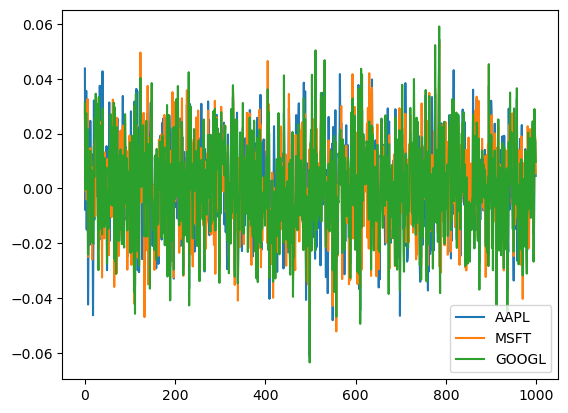

In [18]:
scenarios_df.plot()

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from copulas.univariate import GaussianKDE
from copulas.bivariate import Clayton
from copulas.multivariate import GaussianMultivariate

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2023-12-31'

print("Downloading historical data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)
data = raw_data['Close']  # Using Close prices
returns = data.pct_change().dropna()

# Define the quantiles we want to calculate
quantile_levels = [0.1, 0.5, 0.9]  # 10%, 50%, 90%

# Create empty DataFrame to hold the quantiles for each day (forward-looking)
# We'll use a 20-day rolling window
window_size = 20
quantile_df = pd.DataFrame(index=returns.index[window_size:])

# Calculate rolling quantiles for each asset and each quantile level
for ticker in tickers:
    for q in quantile_levels:
        col_name = f"{ticker}_{int(q*100)}%"
        rolling_quantile = returns[ticker].rolling(window=window_size).quantile(q)
        quantile_df[col_name] = rolling_quantile.iloc[window_size:]

# Estimate the correlation matrix from historical returns
correlation_matrix = returns.corr().values

# Fit marginal distributions using Gaussian Kernel Density Estimation
marginals = {}
for ticker in tickers:
    kde = GaussianKDE()
    kde.fit(returns[ticker].values.reshape(-1, 1))
    marginals[ticker] = kde

# Fit a Gaussian copula to model dependencies
copula = GaussianMultivariate()
copula.fit(returns)

# Number of scenarios to generate
num_scenarios = 1000

# Generate scenarios
samples = copula.sample(num_scenarios)

# Transform samples to original scale using inverse CDFs of marginals
scenarios = pd.DataFrame(index=range(num_scenarios), columns=tickers)
for i, ticker in enumerate(tickers):
    scenarios[ticker] = marginals[ticker].inverse_transform(samples[:, i])

# Display the first few scenarios
print(scenarios.head())


[*********************100%***********************]  3 of 3 completed

ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

In [20]:
import numpy as np
from scipy import stats

# 1. Define our quantile information
quantiles = [0.1, 0.5, 0.9]
# Values for Variable 1 at these quantiles
var1_values = [10, 20, 40]  
# Values for Variable 2 at these quantiles
var2_values = [100, 150, 250]
# Values for Variable 3 at these quantiles
var3_values = [5, 15, 35]

# 2. Define target correlation matrix
target_corr = np.array([
    [1.0, 0.7, 0.4],  # Correlations for Var1
    [0.7, 1.0, 0.5],  # Correlations for Var2
    [0.4, 0.5, 1.0]   # Correlations for Var3
])

# 3. Generate correlated normal random variables
n_samples = 1000
L = np.linalg.cholesky(target_corr)  # Cholesky decomposition
Z = np.random.standard_normal((3, n_samples))  # Independent normal variables
X = np.dot(L, Z).T  # Correlated normal variables

# 4. Transform to uniform distributions using normal CDF
U = stats.norm.cdf(X)  # U contains uniform variables with desired correlation

# 5. Transform uniform values to match our target quantiles
result = np.zeros_like(U)

# Simple function to transform uniform values to target distribution
def transform_to_target(u, target_values):
    result = np.zeros_like(u)
    
    # For each segment between quantiles
    for i in range(len(quantiles)-1):
        # Find which points fall in this segment
        mask = (u >= quantiles[i]) & (u <= quantiles[i+1])
        if np.any(mask):
            # Apply linear interpolation
            q1, q2 = quantiles[i], quantiles[i+1]
            v1, v2 = target_values[i], target_values[i+1]
            result[mask] = v1 + (v2-v1)*(u[mask]-q1)/(q2-q1)
    
    # Handle values outside our quantile range
    result[u < quantiles[0]] = target_values[0]
    result[u > quantiles[-1]] = target_values[-1]
    
    return result

# Apply transformation to each variable
result[:, 0] = transform_to_target(U[:, 0], var1_values)
result[:, 1] = transform_to_target(U[:, 1], var2_values)
result[:, 2] = transform_to_target(U[:, 2], var3_values)

# 6. Verify results
# Check correlation
actual_corr = np.corrcoef(result.T)
print("Target correlation matrix:")
print(target_corr)
print("\nActual correlation matrix:")
print(actual_corr.round(2))

# Check quantiles
print("\nQuantile values:")
for i, var_name in enumerate(["Var1", "Var2", "Var3"]):
    target = [var1_values, var2_values, var3_values][i]
    actual = np.quantile(result[:, i], quantiles).round(2)
    print(f"{var_name}: Target {target}, Actual {actual}")

Target correlation matrix:
[[1.  0.7 0.4]
 [0.7 1.  0.5]
 [0.4 0.5 1. ]]

Actual correlation matrix:
[[1.   0.66 0.34]
 [0.66 1.   0.44]
 [0.34 0.44 1.  ]]

Quantile values:
Var1: Target [10, 20, 40], Actual [10.   20.25 38.93]
Var2: Target [100, 150, 250], Actual [100.  149.8 248.4]
Var3: Target [5, 15, 35], Actual [ 5.03 15.19 34.95]


In [21]:
import numpy as np
from scipy import stats
import pandas as pd

# 1. Define our quantile information
quantiles = [0.1, 0.5, 0.9]
var1_values = [10, 20, 40]  
var2_values = [100, 150, 250]
var3_values = [5, 15, 35]

# 2. Define target correlation matrix
target_corr = np.array([
    [1.0, 0.7, 0.4],
    [0.7, 1.0, 0.5],
    [0.4, 0.5, 1.0]
])

# 3. Generate correlated normal random variables
n_scenarios = 1000
np.random.seed(42)  # Fixed seed for reproducibility
L = np.linalg.cholesky(target_corr)
Z = np.random.standard_normal((3, n_scenarios))
X = np.dot(L, Z).T

# 4. Transform to uniform distributions
U = stats.norm.cdf(X)

# 5. Transform uniform values to match target quantiles
def transform_to_target(u, target_values):
    result = np.zeros_like(u)
    for i in range(len(quantiles)-1):
        mask = (u >= quantiles[i]) & (u < quantiles[i+1])
        if np.any(mask):
            q1, q2 = quantiles[i], quantiles[i+1]
            v1, v2 = target_values[i], target_values[i+1]
            result[mask] = v1 + (v2-v1)*(u[mask]-q1)/(q2-q1)
    
    # Handle boundary cases
    result[u < quantiles[0]] = target_values[0]
    result[u >= quantiles[-1]] = target_values[-1]
    return result

# Generate the scenarios with tracking IDs
scenarios = np.zeros((n_scenarios, 3))
scenarios[:, 0] = transform_to_target(U[:, 0], var1_values)
scenarios[:, 1] = transform_to_target(U[:, 1], var2_values)
scenarios[:, 2] = transform_to_target(U[:, 2], var3_values)

# 6. Create a DataFrame with scenario IDs for tracking
scenarios_df = pd.DataFrame(
    scenarios, 
    columns=['Var1', 'Var2', 'Var3']
)
scenarios_df['scenario_id'] = np.arange(n_scenarios)

In [22]:
scenarios_df

,Var1,Var2,Var3,scenario_id
0,29.515234,250.000000,15.936488,0
1,18.625394,203.366215,17.086464,1
2,32.070340,197.510251,11.054101,2
3,40.000000,206.779154,17.864187,3
4,17.685824,182.770821,5.000000,4
...,...,...,...,...
995,17.232918,203.700631,20.591897,995
996,40.000000,248.102203,31.234586,996
997,31.959380,141.013434,5.961796,997
998,14.598479,125.353749,15.194515,998


Cross-correlation at each time point:
Time 0: Correlation matrix
[[1.   0.6  0.21]
 [0.6  1.   0.33]
 [0.21 0.33 1.  ]]
Time 1: Correlation matrix
[[1.   0.62 0.19]
 [0.62 1.   0.3 ]
 [0.19 0.3  1.  ]]
Time 2: Correlation matrix
[[1.   0.73 0.32]
 [0.73 1.   0.45]
 [0.32 0.45 1.  ]]

Quantile values at each time point:
Time 0:
  Var1: Target [10, 20, 40], Actual [10.65 18.22 37.08]
  Var2: Target [100, 150, 250], Actual [100.14 141.81 249.95]
  Var3: Target [5, 15, 35], Actual [ 5.09 15.08 34.2 ]
Time 1:
  Var1: Target [10, 20, 40], Actual [10.99 19.5  35.64]
  Var2: Target [100, 150, 250], Actual [103.27 142.48 248.99]
  Var3: Target [5, 15, 35], Actual [ 5.   14.58 34.01]
Time 2:
  Var1: Target [10, 20, 40], Actual [10.6  19.24 40.  ]
  Var2: Target [100, 150, 250], Actual [102.55 145.27 250.  ]
  Var3: Target [5, 15, 35], Actual [ 5.57 14.25 32.41]


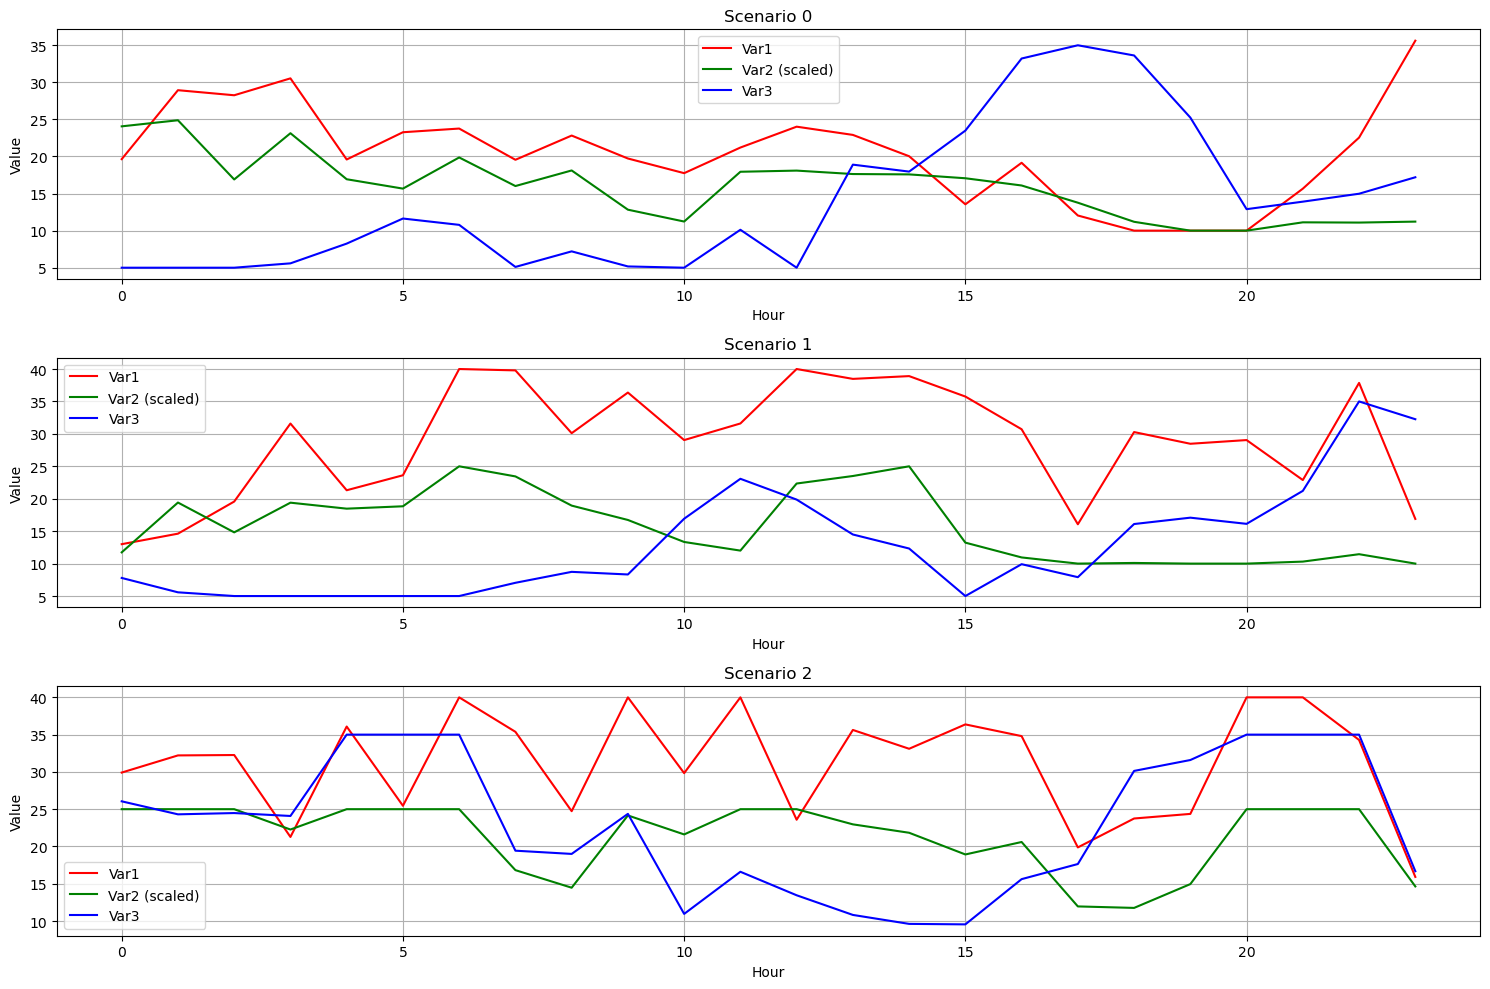

In [23]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define time points (24 hours) and number of scenarios
n_times = 24
n_scenarios = 100
time_points = np.arange(n_times)

# 2. Define our quantile information
quantiles = [0.1, 0.5, 0.9]
var1_values = [10, 20, 40]  
var2_values = [100, 150, 250]
var3_values = [5, 15, 35]

# 3. Define target correlation matrix
target_corr = np.array([
    [1.0, 0.7, 0.4],
    [0.7, 1.0, 0.5],
    [0.4, 0.5, 1.0]
])

# 4. Generate correlated time series
np.random.seed(42)  # For reproducibility

# Function to transform uniform values to target distribution
def transform_to_target(u, target_values):
    result = np.zeros_like(u)
    for i in range(len(quantiles)-1):
        mask = (u >= quantiles[i]) & (u < quantiles[i+1])
        if np.any(mask):
            q1, q2 = quantiles[i], quantiles[i+1]
            v1, v2 = target_values[i], target_values[i+1]
            result[mask] = v1 + (v2-v1)*(u[mask]-q1)/(q2-q1)
    
    # Handle boundary cases
    result[u < quantiles[0]] = target_values[0]
    result[u >= quantiles[-1]] = target_values[-1]
    return result

# Generate scenarios
all_scenarios = []

for scenario_id in range(n_scenarios):
    # Create temporal correlation matrix (AR(1) process with correlation 0.8)
    temporal_corr = np.zeros((n_times, n_times))
    for i in range(n_times):
        for j in range(n_times):
            temporal_corr[i, j] = 0.8 ** abs(i-j)
    
    # Generate correlated time series for each variable
    scenario_data = []
    
    # Cholesky decomposition for temporal correlation
    L_temporal = np.linalg.cholesky(temporal_corr)
    
    # Cholesky decomposition for cross-correlation
    L_cross = np.linalg.cholesky(target_corr)
    
    # Generate base random values
    Z = np.random.standard_normal((n_times, 3))
    
    # Apply temporal correlation
    X_temporal = np.dot(L_temporal, np.random.standard_normal((n_times, 3)))
    
    # Apply cross-correlation
    X = np.zeros_like(X_temporal)
    for t in range(n_times):
        X[t] = np.dot(L_cross, X_temporal[t])
    
    # Transform to uniform
    U = stats.norm.cdf(X)
    
    # Transform to target distributions
    result = np.zeros_like(U)
    result[:, 0] = transform_to_target(U[:, 0], var1_values)
    result[:, 1] = transform_to_target(U[:, 1], var2_values)
    result[:, 2] = transform_to_target(U[:, 2], var3_values)
    
    # Create DataFrame for this scenario
    scenario_df = pd.DataFrame(result, columns=['Var1', 'Var2', 'Var3'])
    scenario_df['time'] = time_points
    scenario_df['scenario_id'] = scenario_id
    
    all_scenarios.append(scenario_df)

# Combine all scenarios
combined_scenarios = pd.concat(all_scenarios, ignore_index=True)

# 5. Verify results

# Check cross-correlation at each time point
print("Cross-correlation at each time point:")
for t in range(n_times):
    time_data = combined_scenarios[combined_scenarios['time'] == t]
    corr = time_data[['Var1', 'Var2', 'Var3']].corr().values
    print(f"Time {t}: Correlation matrix")
    print(corr.round(2))
    if t == 2:  # Just show a few examples
        break

# Check quantiles at each time point
print("\nQuantile values at each time point:")
for t in range(n_times):
    time_data = combined_scenarios[combined_scenarios['time'] == t]
    print(f"Time {t}:")
    for i, var_name in enumerate(['Var1', 'Var2', 'Var3']):
        target = [var1_values, var2_values, var3_values][i]
        actual = np.quantile(time_data[var_name], quantiles).round(2)
        print(f"  {var_name}: Target {target}, Actual {actual}")
    if t == 2:  # Just show a few examples
        break

# 6. Plot a few example scenarios
plt.figure(figsize=(15, 10))

# Plot 3 random scenarios
sample_scenarios = [0, 1, 2]
colors = ['r', 'g', 'b']

for i, scenario_id in enumerate(sample_scenarios):
    scenario_data = combined_scenarios[combined_scenarios['scenario_id'] == scenario_id]
    
    plt.subplot(3, 1, i+1)
    plt.plot(scenario_data['time'], scenario_data['Var1'], color=colors[0], label='Var1')
    plt.plot(scenario_data['time'], scenario_data['Var2']/10, color=colors[1], label='Var2 (scaled)')
    plt.plot(scenario_data['time'], scenario_data['Var3'], color=colors[2], label='Var3')
    plt.title(f'Scenario {scenario_id}')
    plt.xlabel('Hour')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('correlated_time_series.png')